In [1]:
import datetime
import os

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-white')

from ooi_data_explorations.common import list_deployments, get_deployment_dates, get_vocabulary, m2m_request, \
    m2m_collect, update_dataset, CONFIG, ENCODINGS
from ooi_data_explorations.uncabled.process_dosta import dosta_ctdbp_datalogger, dosta_datalogger

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setup needed parameters for the request for CE06ISSM
site = 'CE06ISSM'           # OOI Net site designator
node = 'RID16'              # OOI Net node designator
sensor = '03-DOSTAD000'     # OOI Net sensor designator
stream = 'dosta_abcdjm_ctdbp_dcl_instrument'  # OOI Net stream name
method = 'telemetered'      # OOI Net data delivery method

# Set the start date to June 1, 2020. Leaving the stop date empty will request through the end of the record.
start = '2025-04-01T00:00:00.000Z'    # explicit date/time format required for M2M requests

# request the data
r = m2m_request(site, node, sensor, method, stream, start)

Requesting:
	refdes: CE06ISSM-RID16-03-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_ctdbp_dcl_instrument
	from 2025-04-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [04:30<00:00,  1.48it/s]


In [3]:
# collect and download the DOSTA data from the NSIF in an xarray dataset
nsif06 = m2m_collect(r, '.*DOSTA.*\\.nc$')

Merging the data files into a single dataset


In [4]:
# CE06ISSM MFN
r = m2m_request(site, 'MFD37', sensor, method, stream, start)
mfn06 = m2m_collect(r, '.*DOSTA.*\\.nc$')

# CE07SHSM NSIF
r = m2m_request('CE07SHSM', 'RID27', '04-DOSTAD000', method, 'dosta_abcdjm_dcl_instrument', start)
nsif07 = m2m_collect(r, '.*DOSTA.*\\.nc$')

# CE07SHSM MFN
r = m2m_request('CE07SHSM', 'MFD37', sensor, method, stream, start)
mfn07 = m2m_collect(r, '.*DOSTA.*\\.nc$')

Requesting:
	refdes: CE06ISSM-MFD37-03-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_ctdbp_dcl_instrument
	from 2025-04-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [04:00<00:00,  1.66it/s]


Merging the data files into a single dataset
Requesting:
	refdes: CE07SHSM-RID27-04-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_dcl_instrument
	from 2025-04-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [04:30<00:00,  1.48it/s]


Merging the data files into a single dataset
Requesting:
	refdes: CE07SHSM-MFD37-03-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_ctdbp_dcl_instrument
	from 2025-04-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [03:30<00:00,  1.90it/s]


Merging the data files into a single dataset


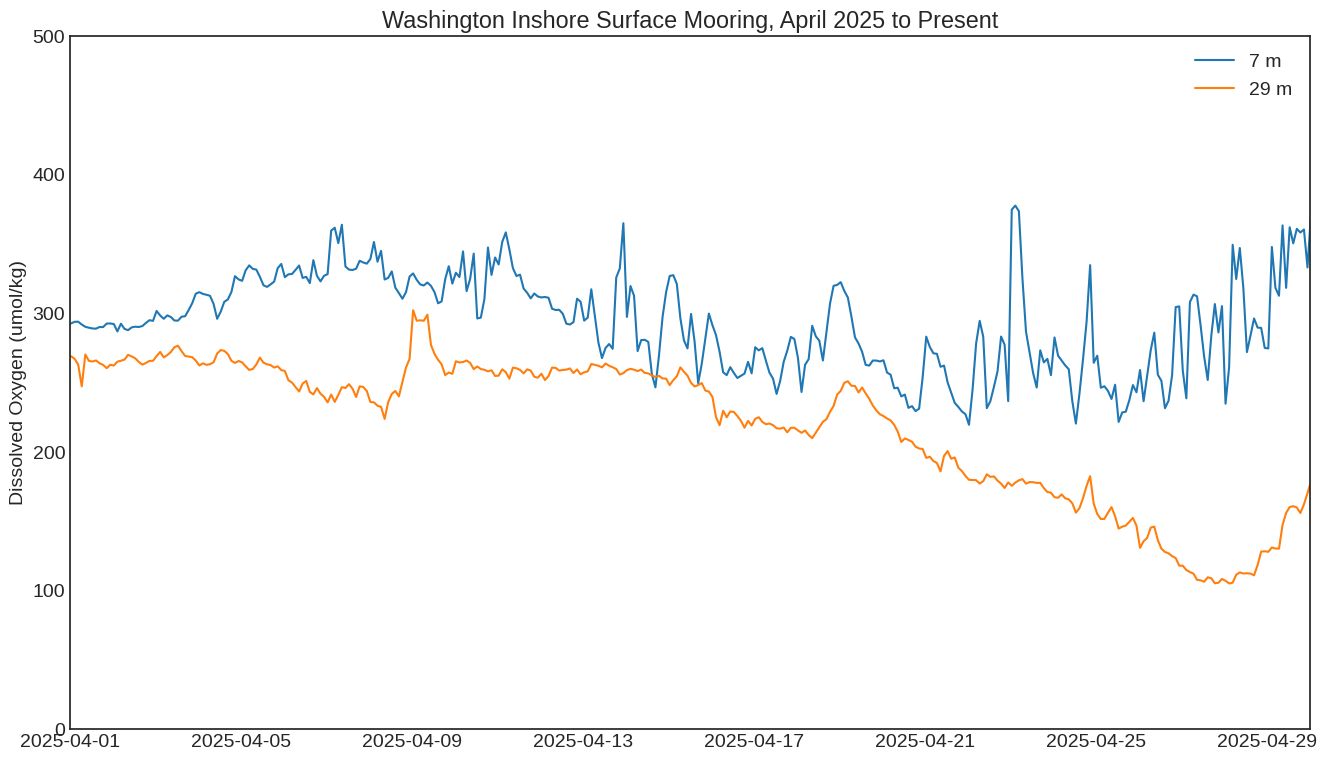

In [5]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.plot(nsif06.time, nsif06.dissolved_oxygen, label='7 m')
plt.plot(mfn06.time, mfn06.dissolved_oxygen, label='29 m')
plt.title('Washington Inshore Surface Mooring, April 2025 to Present')
plt.ylabel('Dissolved Oxygen (umol/kg)')
plt.xlim(datetime.date(2025, 4, 1), datetime.date(2025, 4, 30))
plt.ylim(0, 500)
plt.legend()
plt.show()

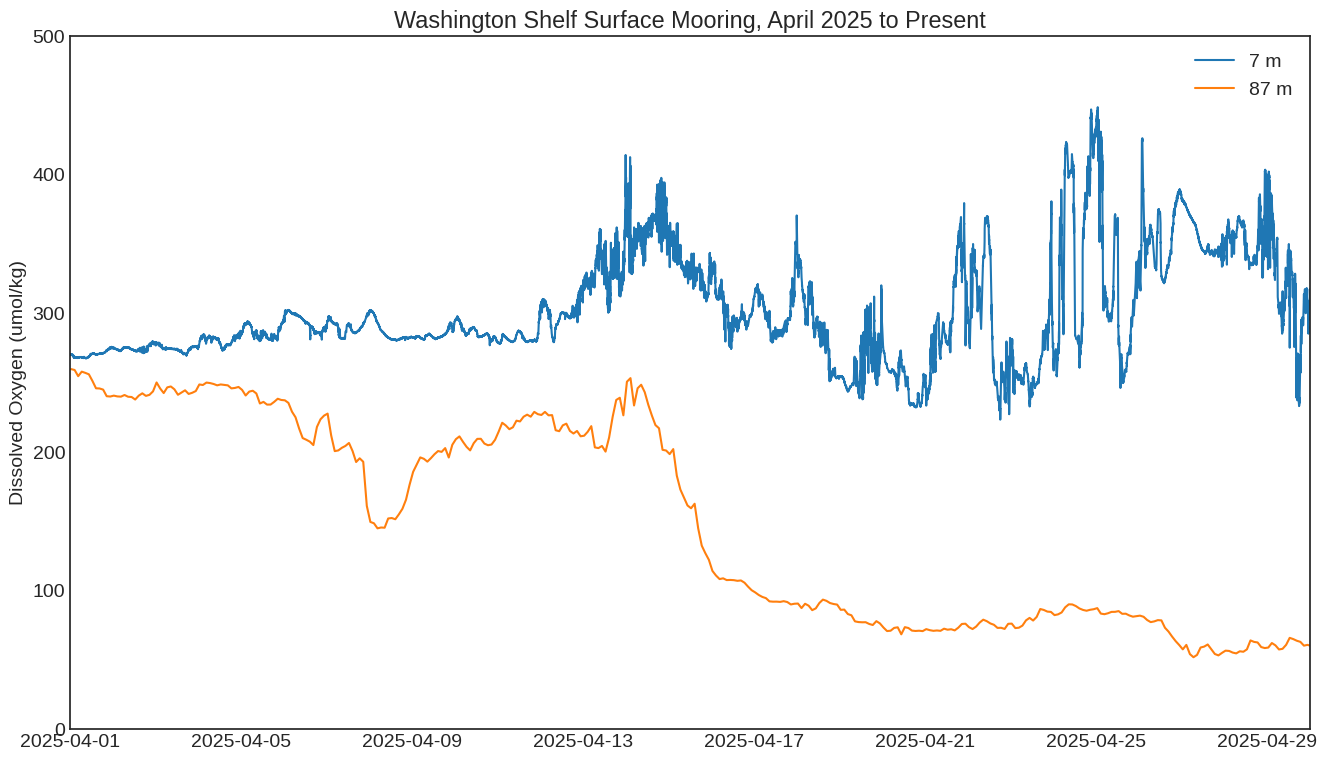

In [6]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.plot(nsif07.time, nsif07.dissolved_oxygen, label='7 m')
plt.plot(mfn07.time, mfn07.dissolved_oxygen, label='87 m')
plt.title('Washington Shelf Surface Mooring, April 2025 to Present')
plt.ylabel('Dissolved Oxygen (umol/kg)')
plt.xlim(datetime.date(2025, 4, 1), datetime.date(2025, 4, 30))
plt.ylim(0, 500)
plt.legend()
plt.show()

In [7]:
def save_dosta(ds, site, level, instrmt):
    home = os.path.expanduser('~')
    m2m_base = os.path.abspath(os.path.join(home, 'ooidata/m2m'))
    out_path = os.path.join(m2m_base, site, level, instrmt)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    out_file = ('%s.%s.%s.Summer2020.nc' % (site, level, instrmt))
    nc_out = os.path.join(out_path, out_file)
    ds.to_netcdf(nc_out, mode='w', format='NETCDF4', engine='h5netcdf', encoding=ENCODINGS)

# clean up, update and save the datasets -- CE06ISSM
nsif06 = dosta_ctdbp_datalogger(nsif06)
nsif06 = update_dataset(nsif06, 7)
save_dosta(nsif06, 'ce06issm', 'nsif', 'dosta')
mfn06 = dosta_ctdbp_datalogger(mfn06)
mfn06 = update_dataset(mfn06, 29)
save_dosta(mfn06, 'ce06issm', 'seafloor', 'dosta')

# clean up, update and save the datasets -- CE07SHSM
nsif07 = dosta_datalogger(nsif07, burst=False)
nsif07 = update_dataset(nsif07, 7)
save_dosta(nsif07, 'ce07shsm', 'nsif', 'dosta')
mfn07 = dosta_ctdbp_datalogger(mfn07)
mfn07 = update_dataset(mfn07, 87)
save_dosta(mfn07, 'ce07shsm', 'seafloor', 'dosta')